<a href="https://colab.research.google.com/github/currencyfxjle/Napoleon_EA_Optimization/blob/main/Strategy_Optimization_EA_Napoleon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ROI % Lossing & Winnings streaks at 1.50 (shocks on equity)

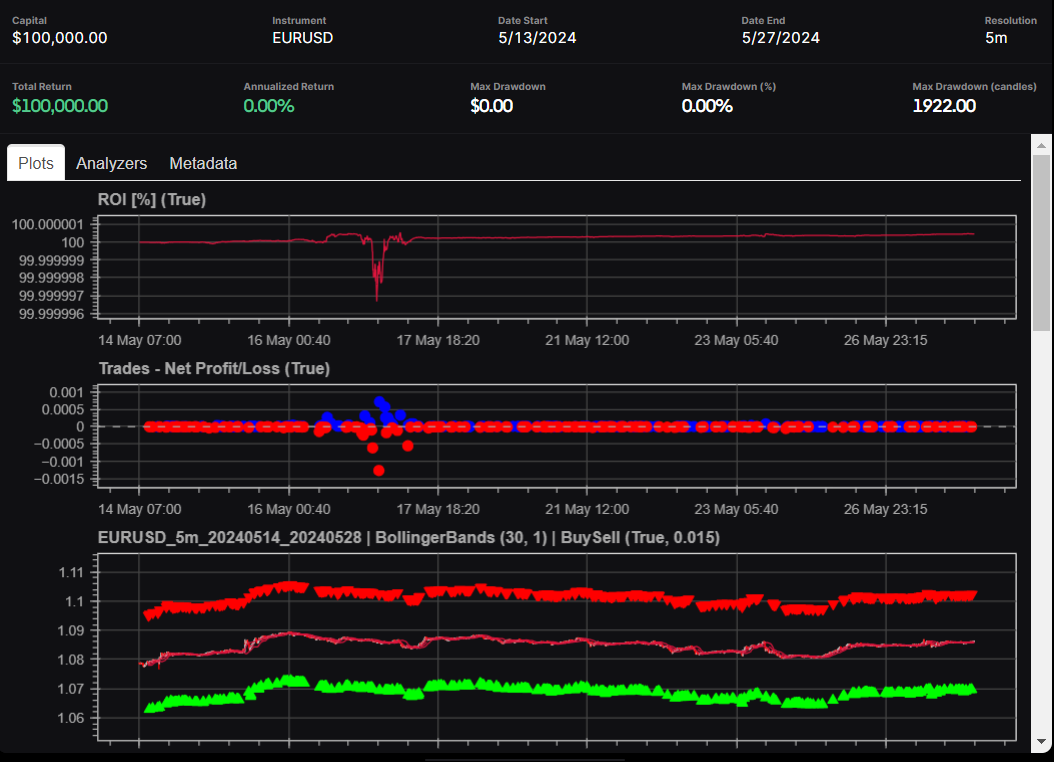

ROI % Martingale on Lossing & Winning streaks at 1.25 (The Martingale at 1.25 has better results than 1.05)

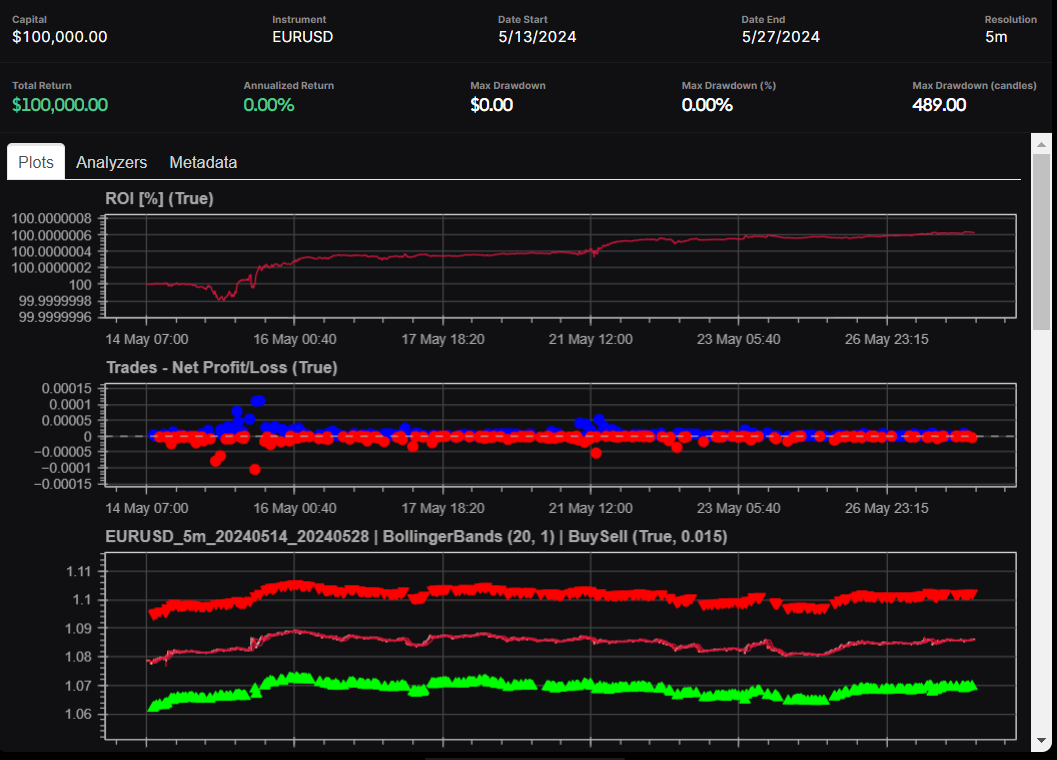

ROI % with martingale on Lossing & winning streaks at 1.05

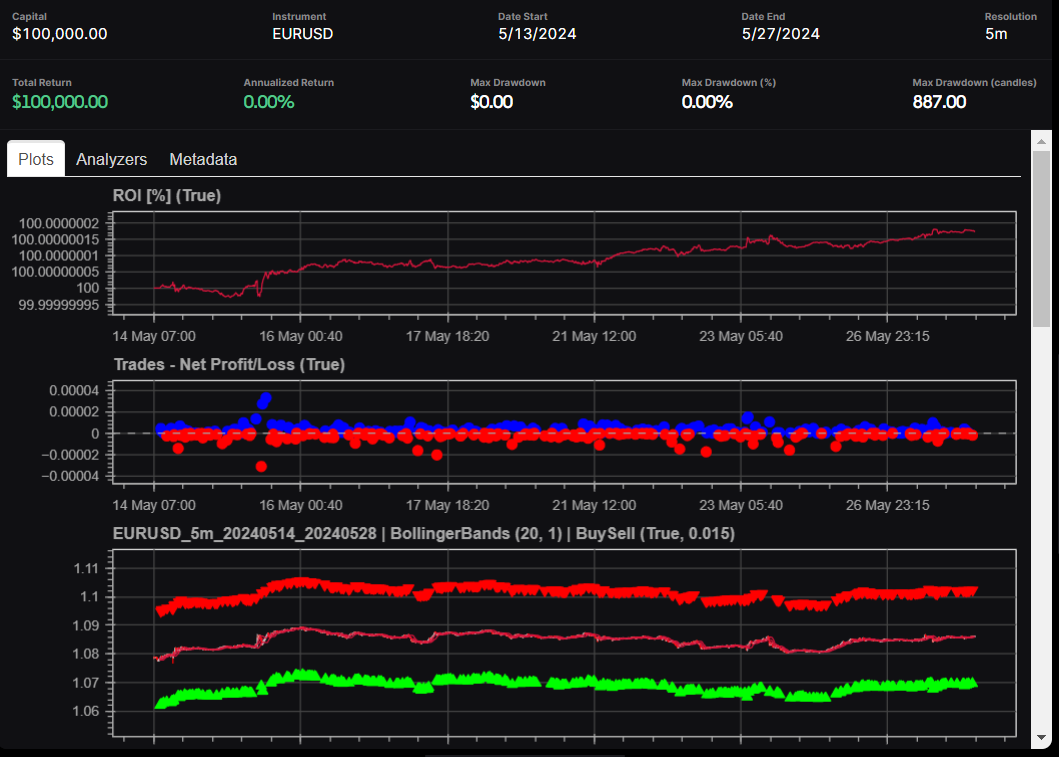

**initial_lot_size (0.01):**

Used to set the initial lot size for trades. It's the starting trade size when a new position is opened.
Example: self.current_lot_size = self.params.initial_lot_size


**tp_in_pips (5):**

Used to calculate the take profit price. It defines how many pips away from the entry price the take profit should be set.
Example: tp_price_full = self.data.close[0] + (self.params.tp_in_pips * self.params._Point * 10)


**multiplier (1.05):**

Used for adjusting the lot size based on winning and losing streaks. It's a factor by which the lot size is increased or decreased.
Example: self.current_lot_size = min(self.params.max_lot_size, self.current_lot_size * self.params.multiplier)


**max_lot_size (7):**

Defines the maximum allowable lot size for any trade to limit exposure.
Example: if lots > self.params.max_lot_size: lots = self.params.max_lot_size


**grid_size (0):**

Determines the spacing for grid trading. If greater than 0, it sets the minimum distance (in pips) between subsequent trades.
Example: if (self.params.grid_size > 0 and (self.data.close[0] - self.data.ask[0]) > (self.params.grid_size * self.params._Point * 10)):


**bb_period (30):**

Sets the period for calculating Bollinger Bands, which are used for generating buy/sell signals.
Example: self.bbands = bt.indicators.BollingerBands(period=self.params.bb_period, devfactor=self.params.bb_devfactor)


**bb_devfactor (1):**

Sets the standard deviation factor for Bollinger Bands. It's used along with the period to calculate the bands.
Example: self.bbands = bt.indicators.BollingerBands(period=self.params.bb_period, devfactor=self.params.bb_devfactor)


**max_spread (10):**

Used to ensure that trades are only taken when the spread is below this value. It helps avoid high transaction costs.
(Not explicitly shown in the code but would typically be used in the trade entry logic.)


**_Point (0.00001):**

Represents the pip value for the instrument being traded. It's used for calculating the take profit and stop loss levels.
Example: tp_price_full = self.data.close[0] + (self.params.tp_in_pips * self.params._Point * 10)


**max_daily_loss (100):**

Sets the maximum allowable loss for the day in currency terms. If exceeded, all trades are closed.
Example: if daily_loss > daily_loss_limit: self.close_all_trades()


**max_monthly_profit (500):**

Sets the maximum target profit for the month. Once reached, trading might be halted (not explicitly shown in the provided code but would be implemented similarly to daily limits).


**close_on_drawdown_percent (5):**

Defines the drawdown percentage at which all trades are closed to protect the account from further losses.
Example: if drawdown > self.params.close_on_drawdown_percent: self.close_all_trades()


**trailing_stop (2):**

Used to set a trailing stop distance (in pips) to lock in profits as the trade moves in the favorable direction.
(Not explicitly shown in the code but would be implemented in trade management logic.)


**max_daily_profit (200):**

Sets a target for daily profit. Once this profit is achieved, no more trades are opened for the day.
Example: if self.realized_daily_profit > self.params.max_daily_profit: self.close_all_trades()


**daily_sl (1):**

Represents the daily stop loss as a percentage of the starting balance. It ensures that daily losses do not exceed this percentage.
Example: daily_loss_limit = self.starting_balance * (self.params.daily_sl / 100)


**partial_profit_pct (50):**

Defines the percentage of the position size to close when the partial take profit level is reached.
Example: partial_size = details['size'] * (self.params.partial_profit_pct / 100)


**partial_profit_distance_pct (30):**

Sets the distance for the partial take profit as a percentage of the total tp_in_pips. This determines how far the partial profit target is from the entry price.
Example: tp_price_partial = self.data.close[0] + (self.params.tp_in_pips * self.params.partial_profit_distance_pct / 100 * self.params._Point * 10)

In [ ]:
!pip install backtrader pandas
import backtrader as bt
import pandas as pd
from datetime import datetime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.5/419.5 kB 4.5 MB/s eta 0:00:00


In [ ]:
import backtrader as bt

class NapoleonEA(bt.Strategy):
    params = (
        ('initial_lot_size', 0.01),  # Initial lot size for trades
        ('tp_in_pips', 5),  # Take profit distance in pips
        ('multiplier', 1.05),  # Multiplier for lot size adjustment in Martingale strategy
        ('max_lot_size', 7),  # Maximum allowable lot size
        ('grid_size', 0),  # Distance in pips for grid trading
        ('bb_period', 20),  # Period for Bollinger Bands calculation
        ('bb_devfactor', 1),  # Standard deviation factor for Bollinger Bands
        ('max_spread', 10),  # Maximum spread allowed for trades
        ('_Point', 0.00001),  # Pip value for the instrument
        ('max_daily_loss', 100),  # Maximum daily loss in currency
        ('max_monthly_profit', 500),  # Maximum monthly profit in currency
        ('close_on_drawdown_percent', 5),  # Drawdown percentage to close all trades
        ('trailing_stop', 2),  # Trailing stop distance in pips
        ('max_daily_profit', 200),  # Maximum daily profit in currency
        ('daily_sl', 1),  # Daily stop loss as a percentage of starting balance
        ('partial_profit_pct', 50),  # Percentage of position to close at partial profit
        ('partial_profit_distance_pct', 30),  # Percentage of tp_in_pips to set partial profit distance
    )

    def __init__(self):
        self.order = None  # To keep track of pending orders
        self.open_trades = {}  # Dictionary to track open trades
        self.order_ref_to_trade_id = {}  # Map order references to trade IDs
        self.bbands = bt.indicators.BollingerBands(period=self.params.bb_period, devfactor=self.params.bb_devfactor)  # Bollinger Bands indicator
        self.realized_daily_profit = 0  # Realized profit for the current day
        self.realized_monthly_profit = 0  # Realized profit for the current month
        self.last_check_date = self.data.datetime.datetime(0).date()  # Date of the last check
        self.highest_account_balance = self.broker.getvalue()  # Track the highest account balance
        self.lot_multiplier = self.params.multiplier  # Multiplier for lot size adjustment
        self.equity_curve = []  # Track equity curve for drawdown calculations
        self.max_drawdown = 0  # Track the maximum drawdown
        self.starting_balance = self.broker.getvalue()  # Starting balance for daily SL calculation

        # Martingale parameters
        self.winning_streak = 0  # Track the number of consecutive winning trades
        self.losing_streak = 0  # Track the number of consecutive losing trades
        self.current_lot_size = self.params.initial_lot_size  # Current lot size for trades

    def notify_order(self, order):
        if order.status in [bt.Order.Completed]:
            trade_id = self.order_ref_to_trade_id[order.ref]
            if trade_id in self.open_trades:
                self.log(f'Order executed: {order.ref}, Price: {order.executed.price}')
        elif order.status in [bt.Order.Canceled, bt.Order.Margin, bt.Order.Rejected]:
            self.log(f'Order Canceled/Margin/Rejected: {order.ref}')
            if order.ref in self.order_ref_to_trade_id:
                trade_id = self.order_ref_to_trade_id[order.ref]
                if trade_id in self.open_trades:
                    del self.open_trades[trade_id]
                del self.order_ref_to_trade_id[order.ref]

    def notify_trade(self, trade):
        if trade.isclosed:
            trade_ids_to_remove = []
            for order_ref, trade_id in self.order_ref_to_trade_id.items():
                if trade_id in self.open_trades:
                    del self.open_trades[trade_id]
                    trade_ids_to_remove.append(order_ref)
                    self.log(f'Trade: {trade_id}')
            for order_ref in trade_ids_to_remove:
                del self.order_ref_to_trade_id[order_ref]
            profit = trade.pnlcomm
            self.realized_daily_profit += profit  # Update realized daily profit
            self.realized_monthly_profit += profit  # Update realized monthly profit

            # Update streaks and adjust lot size
            if profit > 0:
                self.winning_streak += 1
                self.losing_streak = 0
            else:
                self.losing_streak += 1
                self.winning_streak = 0

            self.adjust_lot_size()

    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.date(0)
        print(f'{dt.isoformat()}, {txt}')

    def next(self):
        self.manage_drawdown()  # Manage ongoing drawdown based on account value
        self.check_daily_limits()  # Check and handle daily profit/loss limits
        self.update_equity_curve()  # Update equity curve for drawdown calculations

        # Execute trading signals
        self.execute_trading_signals()

    def execute_trading_signals(self):
        # This method encapsulates your trading signals execution logic
        if self.get_total_buy_orders_count() == 0 and (self.check_buy_signal_trend() or self.check_buy_signal_counter()):
            # Calculate the take profit prices for a buy order
            tp_price_full = self.data.close[0] + (self.params.tp_in_pips * self.params._Point * 10)
            tp_price_partial = self.data.close[0] + (self.params.tp_in_pips * self.params.partial_profit_distance_pct / 100 * self.params._Point * 10)
            # Open a buy market trade with the current lot size and calculated take profit prices
            self.order = self.open_market_trade(self.current_lot_size, tp_price_partial, tp_price_full)

        if self.get_total_sell_orders_count() == 0 and (self.check_sell_signal_trend() or self.check_sell_signal_counter()):
            # Calculate the take profit prices for a sell order
            tp_price_full = self.data.close[0] - (self.params.tp_in_pips * self.params._Point * 10)
            tp_price_partial = self.data.close[0] - (self.params.tp_in_pips * self.params.partial_profit_distance_pct / 100 * self.params._Point * 10)
            # Open a sell market trade with the current lot size and calculated take profit prices
            self.order = self.open_market_trade(-self.current_lot_size, tp_price_partial, tp_price_full)

        # Logic to handle additional buy orders under certain conditions
        if (self.get_total_buy_orders_count() > 0
            and self.order.ref in self.open_trades
            and self.open_trades[self.order.ref]['open_time'] != self.data.close[-1]
            and self.data.close[-1] < self.position.price):
            lots = self.current_lot_size
            if lots > self.params.max_lot_size:
                lots = self.params.max_lot_size

            tp_price_full = self.data.close[0] + (self.params.tp_in_pips * self.params._Point * 10)
            tp_price_partial = self.data.close[0] + (self.params.tp_in_pips * self.params.partial_profit_distance_pct / 100 * self.params._Point * 10)

            if (self.params.grid_size > 0
                and (self.data.close[0] - self.data.ask[0]) > (self.params.grid_size * self.params._Point * 10)):
                self.order = self.open_market_trade(lots, tp_price_partial, tp_price_full)
            elif self.params.grid_size == 0:
                self.order = self.open_market_trade(lots, tp_price_partial, tp_price_full)

        if (self.get_total_sell_orders_count() > 0
            and self.order.ref in self.open_trades
            and self.open_trades[self.order.ref]['open_time'] != self.data.close[-1]
            and self.data.close[-1] > self.position.price):
            lots = self.current_lot_size
            if lots > self.params.max_lot_size:
                lots = self.params.max_lot_size

            tp_price_full = self.data.close[0] - (self.params.tp_in_pips * self.params._Point * 10)
            tp_price_partial = self.data.close[0] - (self.params.tp_in_pips * self.params.partial_profit_distance_pct / 100 * self.params._Point * 10)

            if (self.params.grid_size > 0
                and (self.data.close[0] - self.data.ask[0]) > (self.params.grid_size * self.params._Point * 10)):
                self.order = self.open_market_trade(-lots, tp_price_partial, tp_price_full)
            elif self.params.grid_size == 0:
                self.order = self.open_market_trade(-lots, tp_price_partial, tp_price_full)

    def open_market_trade(self, lots, tp_price_partial, tp_price_full):
        # Place a market order (buy or sell) and set the take profit prices
        order = self.buy(size=lots, exectype=bt.Order.Market) if lots > 0 else self.sell(size=-lots, exectype=bt.Order.Market)
        trade_id = f"{order.ref}_{self.data.datetime.date(0)}"
        self.order_ref_to_trade_id[order.ref] = trade_id
        self.open_trades[trade_id] = {
            'price': order.executed.price,
            'size': abs(lots),
            'type': 'buy' if lots > 0 else 'sell',
            'open_time': self.data.num2date(order.executed.dt),
            'tp_price_partial': tp_price_partial,
            'tp_price_full': tp_price_full
        }
        return order

    def check_take_profit(self):
        for order_ref, details in list(self.open_trades.items()):  # Iterate over a copy to modify dict
            current_price = self.data.close[0]
            if details['tp_price_partial'] is not None:
                if current_price >= details['tp_price_partial'] and details['type'] == 'buy':
                    # Execute partial take profit for buy orders
                    partial_size = details['size'] * (self.params.partial_profit_pct / 100)
                    self.close(size=partial_size)
                    self.open_trades[order_ref]['size'] -= partial_size
                    self.open_trades[order_ref]['tp_price_partial'] = None  # Ensure partial TP is only executed once
                    self.log(f'Partial take profit executed: {order_ref} at price {current_price}')

                if current_price <= details['tp_price_partial'] and details['type'] == 'sell':
                    # Execute partial take profit for sell orders
                    partial_size = details['size'] * (self.params.partial_profit_pct / 100)
                    self.close(size=partial_size)
                    self.open_trades[order_ref]['size'] -= partial_size
                    self.open_trades[order_ref]['tp_price_partial'] = None  # Ensure partial TP is only executed once
                    self.log(f'Partial take profit executed: {order_ref} at price {current_price}')

            if current_price >= details['tp_price_full'] and details['type'] == 'buy':
                # Execute full take profit for buy orders
                self.close(size=details['size'])
                del self.open_trades[order_ref]
                self.log(f'Full take profit executed: {order_ref} at price {current_price}')

            if current_price <= details['tp_price_full'] and details['type'] == 'sell':
                # Execute full take profit for sell orders
                self.close(size=details['size'])
                del self.open_trades[order_ref]
                self.log(f'Full take profit executed: {order_ref} at price {current_price}')

    def check_buy_signal_trend(self):
        # Check for buy signal based on trend strategy using Bollinger Bands
        return (self.data.close[-2] < self.bbands.lines.top[-2] and
                self.data.close[-1] < self.bbands.lines.top[-1] and
                self.data.close[-1] > self.data.open[-1])

    def check_buy_signal_counter(self):
        # Check for buy signal based on counter-trend strategy using Bollinger Bands
        return ((self.data.close[-2] > self.bbands.lines.bot[-2] and
                 self.data.close[-1] < self.bbands.lines.bot[-1]) or
                (self.data.close[-1] < self.bbands.lines.bot[-1] and
                 self.data.close[-1] > self.data.low[-1]))

    def check_sell_signal_trend(self):
        # Check for sell signal based on trend strategy using Bollinger Bands
        return (self.data.close[-2] > self.bbands.lines.bot[-2] and
                self.data.close[-1] > self.bbands.lines.bot[-1] and
                self.data.close[-1] < self.data.open[-1])

    def check_sell_signal_counter(self):
        # Check for sell signal based on counter-trend strategy using Bollinger Bands
        return ((self.data.close[-2] < self.bbands.lines.top[-2] and
                 self.data.close[-1] > self.bbands.lines.top[-1]) or
                (self.data.close[-1] > self.bbands.lines.top[-1] and
                 self.data.close[-1] < self.data.high[-1]))

    def get_average_buy_entry_price(self):
        # Calculate the average entry price for all buy trades
        total_cost = sum(trade['price'] * trade['size'] for trade_id, trade in self.open_trades.items() if trade['type'] == 'buy')
        total_size = sum(trade['size'] for trade_id, trade in self.open_trades.items() if trade['type'] == 'buy')
        return total_cost / total_size if total_size else 0

    def get_average_sell_entry_price(self):
        # Calculate the average entry price for all sell trades
        total_cost = sum(trade['price'] * trade['size'] for trade_id, trade in self.open_trades.items() if trade['type'] == 'sell')
        total_size = sum(trade['size'] for trade_id, trade in self.open_trades.items() if trade['type'] == 'sell')
        return total_cost / total_size if total_size else 0

    def get_total_buy_orders_count(self):
        # Get the total count of open buy orders
        return sum(1 for trade_id, trade in self.open_trades.items() if trade['type'] == 'buy')

    def get_total_sell_orders_count(self):
        # Get the total count of open sell orders
        return sum(1 for trade_id, trade in self.open_trades.items() if trade['type'] == 'sell')

    def get_unrealized_pnl(self):
        # Calculate the unrealized profit and loss for the current position
        if not self.position:
            return 0
        buy_avg_price = self.position.price
        current_price = self.data.close[0]
        position_size = self.position.size
        unrealized_pnl = (current_price - buy_avg_price) * position_size
        normalized_unrealized_pnl = round(unrealized_pnl, 2)
        return normalized_unrealized_pnl

    def modify_tp_for_buy_trades(self, tp_price):
        # Modify take profit price for all buy trades
        current_price = self.data.close[0]
        for order_ref, trade_id in self.order_ref_to_trade_id.items():
            trade_type = self.open_trades[trade_id]['type']
            tp_price = self.open_trades[trade_id]['tp_price']
            if trade_type == 'buy' and current_price >= tp_price:
                self.close(self.open_trades[trade_id]['size'])

    def modify_tp_for_sell_trades(self, tp_price):
        # Modify take profit price for all sell trades
        current_price = self.data.close[0]
        for order_ref, trade_id in self.order_ref_to_trade_id.items():
            trade_type = self.open_trades[trade_id]['type']
            tp_price = self.open_trades[trade_id]['tp_price']
            if trade_type == 'sell' and current_price <= tp_price:
                self.close(self.open_trades[trade_id]['size'])

    def manage_drawdown(self):
        # Manage ongoing drawdown based on account value
        current_balance = self.broker.getvalue()
        if (current_balance > self.highest_account_balance):
            self.highest_account_balance = current_balance
        drawdown = (self.highest_account_balance - current_balance) / self.highest_account_balance * 100
        if drawdown > self.params.close_on_drawdown_percent:
            self.log(f'Drawdown exceeded {self.params.close_on_drawdown_percent}%, closing all trades.')
            self.close_all_trades()

    def close_all_trades(self):
        # Close all open trades
        for trade_id in list(self.open_trades.keys()):
            self.close(self.open_trades[trade_id]['size'])
            self.log('All positions closed due to drawdown.')

    def check_daily_limits(self):
        # Check and handle daily profit/loss limits
        daily_loss_limit = self.starting_balance * (self.params.daily_sl / 100)
        current_balance = self.broker.getvalue()
        daily_loss = self.starting_balance - current_balance

        if daily_loss > daily_loss_limit:
            self.log(f'Daily loss limit exceeded: {daily_loss} > {daily_loss_limit}, all trades closed.')
            self.close_all_trades()
        elif self.realized_daily_profit > self.params.max_daily_profit:
            self.log('Daily profit target achieved, all trades closed.')
            self.close_all_trades()

    def adjust_lot_size(self):
        # Adjust the lot size based on the winning and losing streaks
        if self.winning_streak > 0:
            self.current_lot_size = max(self.params.initial_lot_size, self.current_lot_size / self.params.multiplier)
        elif self.losing_streak > 0:
            self.current_lot_size = min(self.params.max_lot_size, self.current_lot_size * self.params.multiplier)

    def update_equity_curve(self):
        # Update equity curve for drawdown calculations
        current_balance = self.broker.getvalue()
        self.equity_curve.append(current_balance)
        peak = max(self.equity_curve, default=current_balance)
        drawdown = (peak - current_balance) / peak
        self.max_drawdown = max(self.max_drawdown, drawdown)


Backtest to CSV with Comission simulated

In [ ]:
# Load data
data = pd.read_csv('/content/1MIN_EURUSD_OHLC.csv', index_col='DateTime', parse_dates=True)
data_feed = bt.feeds.PandasData(dataname=data)

# Set up Cerebro
cerebro = bt.Cerebro()
cerebro.addstrategy(NapoleonEA)
cerebro.adddata(data_feed)
cerebro.broker.set_cash(10000)
cerebro.broker.setcommission(commission=0.0002)
cerebro.addsizer(bt.sizers.FixedSize, stake=1)
cerebro.run()
cerebro.plot()

Machine Learning with GridSearch to avoid OverFitting

In [ ]:
import backtrader as bt
import pandas as pd
from itertools import product
import numpy as np

# Load data
data = pd.read_csv('/content/1MIN_EURUSD_OHLC.csv', index_col='DateTime', parse_dates=True)
data_feed = bt.feeds.PandasData(dataname=data)

# Define the strategy (same as in the previous script)

# Define the range of parameters to search
param_grid = {
    'initial_lot_size': [0.01, 0.02],
    'tp_in_pips': [5, 10],
    'multiplier': [1.05, 1.1],
    'max_lot_size': [7, 10],
    'bb_period': [20, 30],
    'bb_devfactor': [1, 2],
    'close_on_drawdown_percent': [5, 10],
    'partial_profit_pct': [50, 75],
    'partial_profit_distance_pct': [30, 50],
}

# Create a parameter grid
param_combinations = list(product(*param_grid.values()))
param_names = list(param_grid.keys())

best_params = None
best_profit = -np.inf
no_improvement_counter = 0
max_no_improvement = 10  # Stop after 10 iterations without improvement

for param_values in param_combinations:
    if no_improvement_counter >= max_no_improvement:
        break

    params = dict(zip(param_names, param_values))

    # Set up Cerebro
    cerebro = bt.Cerebro()
    cerebro.addstrategy(NapoleonEA, **params)
    cerebro.adddata(data_feed)
    cerebro.broker.set_cash(10000)
    cerebro.broker.setcommission(commission=0.0002)
    cerebro.addsizer(bt.sizers.FixedSize, stake=1)

    # Run the strategy
    results = cerebro.run()
    final_value = cerebro.broker.getvalue()

    # Check for best performance
    if final_value > best_profit:
        best_profit = final_value
        best_params = params
        no_improvement_counter = 0
    else:
        no_improvement_counter += 1

print('Best Parameters:', best_params)
print('Best Final Value:', best_profit)


Se truncaron las últimas líneas 5000 del resultado de transmisión.
2023-03-13, Trade: 33803_2023-03-13
2023-03-13, Order executed: 33804, Price: 1.06773
2023-03-13, Order executed: 33805, Price: 1.067895
2023-03-13, Trade: 33804_2023-03-13
2023-03-13, Trade: 33805_2023-03-13
2023-03-13, Order executed: 33806, Price: 1.068
2023-03-13, Order executed: 33807, Price: 1.06744
2023-03-13, Trade: 33806_2023-03-13
2023-03-13, Trade: 33807_2023-03-13
2023-03-13, Order executed: 33808, Price: 1.0670700000000002
2023-03-13, Order executed: 33809, Price: 1.06745
2023-03-13, Trade: 33808_2023-03-13
2023-03-13, Trade: 33809_2023-03-13
2023-03-13, Order executed: 33810, Price: 1.06686
2023-03-13, Order executed: 33811, Price: 1.0670799999999998
2023-03-13, Trade: 33810_2023-03-13
2023-03-13, Trade: 33811_2023-03-13
2023-03-13, Order executed: 33812, Price: 1.066905
2023-03-13, Order executed: 33813, Price: 1.0671750000000002
2023-03-13, Trade: 33812_2023-03-13
2023-03-13, Trade: 33813_2023-03-13
2023